In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

In [2]:
import os
import urllib.request

# Download the dataset if not already present
dataset_url = 'https://raw.githubusercontent.com/kristinlussi/DATA_607/main/Project4/spam_ham_dataset.csv'
dataset_file = 'spam_ham_dataset.csv'

if not os.path.exists(dataset_file):
    print('Downloading dataset...')
    urllib.request.urlretrieve(dataset_url, dataset_file)
    print('Download complete.')

data = pd.read_csv(dataset_file, encoding='latin-1')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
data[1990:2000]
data['label'].value_counts()
import nltk
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')
ham_words = ''
spam_words = ''
# Creating a corpus of spam messages
for val in data[data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

# Creating a corpus of ham messages
for val in data[data['label'] == 'ham'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saisrikardevasani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


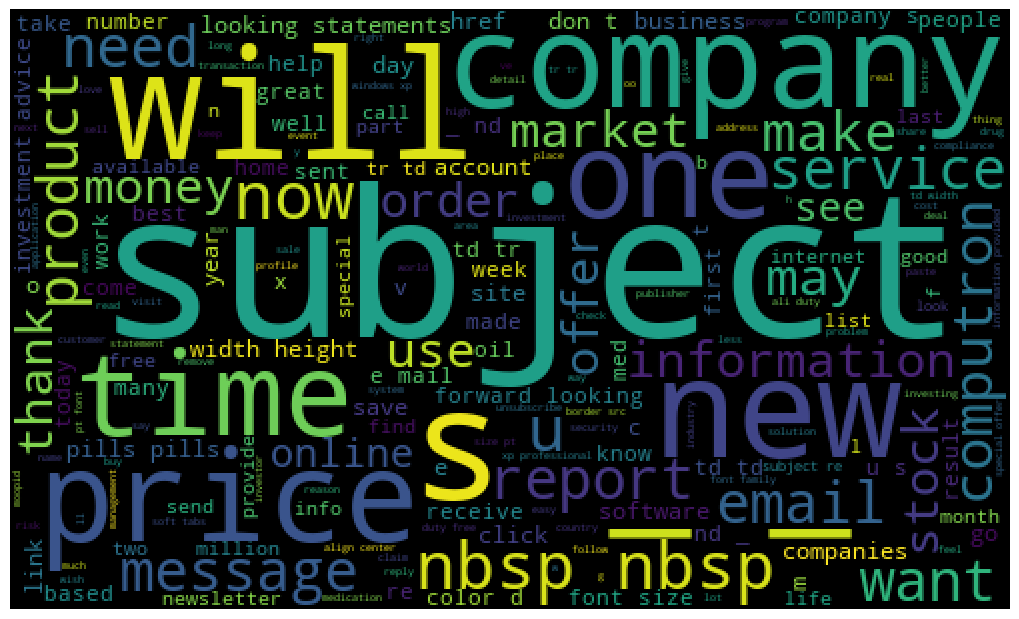

In [4]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

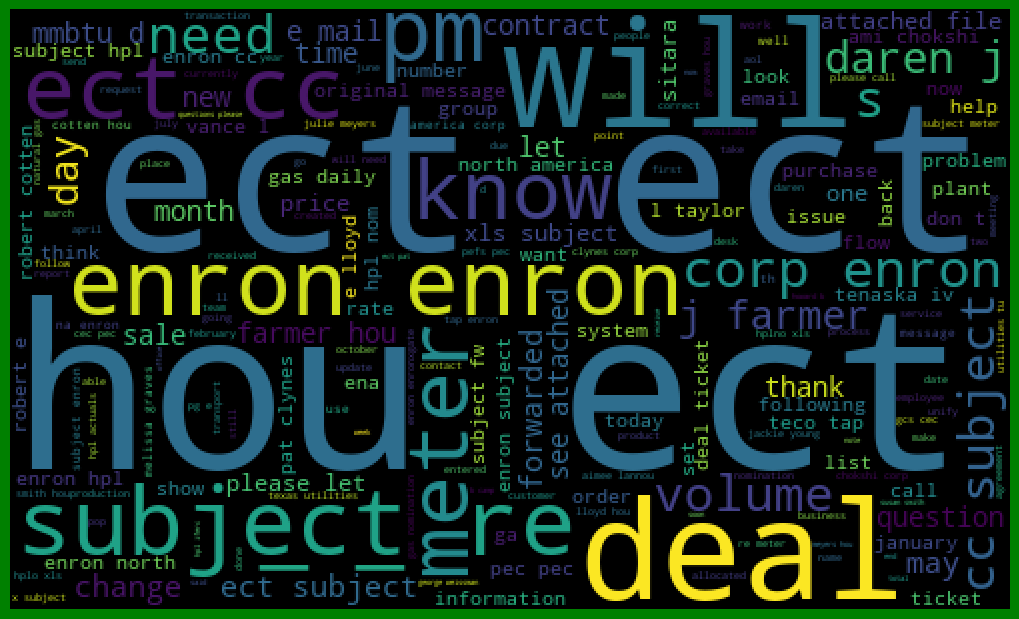

In [5]:
#Creating Ham wordcloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
print(ham_wordcloud)

In [6]:
data = data.replace(['ham','spam'],[0, 1])
data.head(10)

,Unnamed: 0,label,text,label_num
0,605,0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,0,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,0,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,1,"Subject: photoshop , windows , office . cheap ...",1
4,2030,0,Subject: re : indian springs\r\nthis deal is t...,0
5,2949,0,Subject: ehronline web address change\r\nthis ...,0
6,2793,0,Subject: spring savings certificate - take 30 ...,0
7,4185,1,Subject: looking for medication ? we ` re the ...,1
8,2641,0,Subject: noms / actual flow for 2 / 26\r\nwe a...,0
9,1870,0,"Subject: nominations for oct . 21 - 23 , 2000\...",0


In [7]:
import nltk
nltk.download('stopwords')

#remove the punctuations and stopwords
import string
def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

data['text'] = data['text'].apply(text_process)
data.head()
text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])
## Counting how many times a word appears in the dataset

from collections import Counter

total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))
# Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}

#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word]=i
# Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)
# Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for i, (_, text_) in enumerate(text.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])

word_vectors.shape
#convert the text data into vectors
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape
features = vectors
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)
#import sklearn packages for building classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#initialize multiple classification models
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
#create a dictionary of variables and models
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}
#fit the data onto the models
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))
print(pred_scores_word_vectors)
def find(x):
    if x == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")
newtext = [" no 1 in offer "]
integers = vectorizer.transform(newtext)
x = mnb.predict(integers)
find(x)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saisrikardevasani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total words in data set:  50381
['ect', 'hou', 'enron', 'Subject', '2000', 'com', 'please', 'gas', '3', 'subject', 'deal', '1', 'meter', '00', '2', 'cc', 'pm', 'hpl', '000', '10', '2001', 'e', 'daren', 'thanks', '01', 'corp', 'know', '0', '4', '5', 'need', '11', 'new', 'may', 'mmbtu', '12', 'j', 'forwarded', 'get', 'http', '03', 'price', 'see', 'company', 'let', 'information', 'farmer', 'l', 'attached', '7', 'would', '99', '6', '02', 'xls', 'us', 'day', 'time', 'message', '9']


[('SVC', [0.979381443298969]), ('KN', [0.9600515463917526]), ('NB', [0.9858247422680413]), ('DT', [0.9445876288659794]), ('LR', [0.9536082474226805]), ('RF', [0.9716494845360825])]
Message is SPAM
